In [1]:
!pwd

/Users/furiosa/Documents/repos/paper_greekparliament/src


In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import datetime
import re
import os
tqdm.pandas()
from gensim.models.word2vec import Word2Vec
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics.pairwise import cosine_similarity
import tqdm.notebook as tq
from tabulate import tabulate



/Users/furiosa/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/tqdm/std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
df = pd.read_csv('../out_files/tell_all_cleaned.csv')
df = df[df['speech'].notna()]
df.speech = df.speech.progress_apply(lambda x: [sent.split(' ') for sent in x.split('.')])


100%|██████████| 1274505/1274505 [08:40<00:00, 2448.86it/s] 


In [3]:
from tqdm import tqdm
tqdm.pandas()

print(datetime.datetime.now())

#Group speeches by year
PERperiod_df = df.groupby(df.parliamentary_period)['speech'].progress_apply(sum).reset_index()

print(datetime.datetime.now())


/Users/furiosa/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/tqdm/std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


2021-02-28 12:14:50.251141


100%|██████████| 14/14 [5:17:20<00:00, 1360.06s/it]  


2021-02-28 17:32:13.359721


In [4]:
print(PERperiod_df.columns)
print(PERperiod_df.head)
print(type(PERperiod_df))

Index(['parliamentary_period', 'speech'], dtype='object')
<bound method NDFrame.head of    parliamentary_period                                             speech
0             period 10  [[τελος, επιστολη, @sw, βουλευτου, περιφερειας...
1             period 11  [[κυριες, @sw, κυριοι, βουλευτες, κηρυσσεται, ...
2             period 12  [[κυριες, @sw, κυριοι, βουλευτες, κηρυσσεται, ...
3             period 13  [[κυριες, @sw, κυριοι, βουλευτες, κηρυσσεται, ...
4             period 14  [[κυριες, @sw, κυριοι, βουλευτες, συγκαλειται,...
5             period 15  [[κυριες, @sw, κυριοι, βουλευτες, συγκαλειται,...
6             period 16  [[κυριες, @sw, κυριοι, βουλευτες, συγκαλειται,...
7             period 17  [[κυριες, @sw, κυριοι, βουλευτες, συγκαλειται,...
8    period 18 review 9  [[κυριες, @sw, κυριοι, βουλευτες, συγκαλειται,...
9              period 5  [[παρακαλειται, @sw, γραμματεας, βουλγαρακης, ...
10             period 6  [[κυριοι, βουλευτες, κηρυσσουμε, @sw, εναρξη, ...
11          

In [5]:
PERperiod_df = PERperiod_df.rename(columns={'parliamentary_period': 'period'})

# Adjust period 18 name and remove words in order to easily sort periods later on
PERperiod_df.period = PERperiod_df.period.apply(lambda x: x.replace(' review 9',''))
PERperiod_df.period = PERperiod_df.period.apply(lambda x: x.replace('period ',''))

PERperiod_df.period = PERperiod_df.period.astype(int)

Train word2vec models per period

In [6]:
models_dir =  '../out_files/wordmodels/PERperiod/'


In [11]:
models_dir =  '../out_files/wordmodels/PERperiod/'
print(datetime.datetime.now())

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

for period, texts in tqdm(zip(PERperiod_df.period, PERperiod_df.speech)):
    model = Word2Vec(sentences=texts, size=100, window=5, min_count=1, workers=4)
    model.save(models_dir+str(period) + ".mdl")
    
print(datetime.datetime.now())


0it [00:00, ?it/s]

2021-02-20 12:04:15.842982


14it [20:41, 88.65s/it]

2021-02-20 12:24:56.897681


### Implementation of local neighborhood measure for semantic shift from Hamilton's paper
Section 2.1 https://www.aclweb.org/anthology/D16-1229/

Finding: as the topn increases, the average cosine similarity decreases, but more slowly in every step (for the selected topics). Over topn=50 the changes are minor.

In [7]:
vouliwatch_topics = ['αγροτικη', 'αγροτικα', 'αγροτες', 
          'αναπτυξη', 'επενδυσεις', 'επενδυσεων',
          'ασφαλιστικο', 'εργασια', 'εργασιακα', 'δικαιωματα', 'συμβαση', 'συλλογικη', 'μισθος', 'βασικος', 'ημιαπασχοληση', 'brain', 'οαεδ',
          'δικαιοσυνη', 'διαφανεια', 'υιοθεσια',
          'εθνικη', 'αμυνα',
          'εξωτερικη', 'διεθνεις',
          'ναυτιλια','νησια','υδροδοτηση','αλιεια',
          'οικονομια', 'αφορολογητο', 'αποκεντρωση', 'φπα', 'επιχειρησεις', 'φορολογικα', 
          'παιδεια', 'ερευνα', 'προσχολικη', 'ασυλο', 'πανεπιστημιακο', 'δευτεροβαθμια', 'πρωτοβαθμια', 'ανωτατη', 'δημοσια', 'ιδιωτικη', 'σχολες',
          'περιβαλλον', 'ενεργεια', 
          'συστημα',
          'πολιτισμος', 'αθλητισμος', 'πολιτισμο', 'αθλητισμου',
          'προστασια', 'αστυνομια', 'κοκ',
          'προσφυγικο', 'μεταναστευτικο', 
          'τουρισμος', 'τουριστικης', 'τουρισμου',
          'υγεια', 'προνοια', 'επιδοματα', 'επιδομα', 'επιδοματων',
          'υποδομες', 'μεταφορες', 'αναπλαση', #'μμμ',
          'μειωση', 'αυξηση', 'συνταξη', 'μακεδονικο', 'προσληψεις', 'εκας', 'οσε', 'συγκοινωνιες', 'νομοσχεδιο',
                     'θρησκεια', 'γυναικα', 'ανδρας','ομοφυλα', 'εοπυυ'
         ]

In [8]:
def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]

periods = sorted(PERperiod_df.period.to_list())
print(periods)

period_pairs = step_one_pairs(periods)
print(period_pairs)

models = {p:Word2Vec.load(f"../out_files/wordmodels/PERperiod/{p}.mdl") for p in periods}


[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[(5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18)]


In [14]:
similarities_2nd_order = []

for topic in vouliwatch_topics:

    for pair in period_pairs:
        
        t1, t2 = pair[0], pair[1]

        m1 = models[t1]
#         print(m1)
        m2 = models[t2]
        
        if (topic in m1.wv.vocab) and (topic in m2.wv.vocab):
        
            #union of neighbors in two points in time
            neighbors_t1 = [w for w,s in m1.wv.most_similar(positive=[topic], topn=25)]
            neighbors_t2 = [w for w,s in m2.wv.most_similar(positive=[topic], topn=25)]
            neighbors_t1_t2 = list(set(neighbors_t1+neighbors_t2))

            neighbors_union=[]
            # keep neighbors that are included in the compared model vocabularies
            for neighbor in neighbors_t1_t2:
                if (neighbor in m1.wv.vocab) and (neighbor in m2.wv.vocab):
                    neighbors_union.append(neighbor)
        #     print('Union of neighbors: ', str(len(neighbors_union)))

            # similarity vector for time point 1 (t1)
            # each element is the cosine similarity of topic vector in t1 and each neighbor from neighbors_union
            similarity_vector_t1 = []
            topic_vector_t1 = m1.wv[topic]
            for nn in neighbors_union:
                neighbor_vector = m1.wv[nn]
                similarity_vector_t1.append(cosine_similarity(X=topic_vector_t1.reshape(1,-1), Y=neighbor_vector.reshape(1,-1))[0][0])
        #     print(len(similarity_vector_t1))

            # similarity vector for time point 2 (t2)
            # each element is the cosine similarity of topic vector in t2 and each neighbor from neighbors_union
            similarity_vector_t2 = []
            topic_vector_t2 = m2.wv[topic]
            for nn in neighbors_union:
                neighbor_vector = m2.wv[nn]
                similarity_vector_t2.append(cosine_similarity(X=topic_vector_t2.reshape(1,-1), Y=neighbor_vector.reshape(1,-1))[0][0])
        #     print(len(similarity_vector_t2))

            #testing
        #     print(similarity_vector_t1)
        #     print(np.array([similarity_vector_t1]))
            # print(np.array(similarity_vector_t2).reshape(-1, 1))

            # final cosine between cosines/ similarity vectors for t1 and t2
            result = cosine_similarity(np.array([similarity_vector_t1]),
                                       np.array([similarity_vector_t2])
                                      )[0][0]

            similarities_2nd_order.append([topic, pair, result, len(neighbors_union), neighbors_t1, neighbors_t2])
        #     break
        
        else:
            print(topic, ' not in vocabulary for periods ', str(pair))


df_similarities_2nd_order = pd.DataFrame(data=similarities_2nd_order, columns=['topic', 'period_pair', 'cosine_similarity', 'neighbors_union', 'neighbors_t1', 'neighbors_t2'])

df_similarities_2nd_order = df_similarities_2nd_order.sort_values('cosine_similarity', ascending=True).reset_index(drop=True)
print(df_similarities_2nd_order.head(5))
df_similarities_2nd_order.describe()

αγροτικη  not in vocabulary for periods  (13, 14)
αγροτικη  not in vocabulary for periods  (14, 15)
αγροτικα  not in vocabulary for periods  (13, 14)
αγροτικα  not in vocabulary for periods  (14, 15)
αγροτες  not in vocabulary for periods  (13, 14)
αγροτες  not in vocabulary for periods  (14, 15)
αναπτυξη  not in vocabulary for periods  (13, 14)
αναπτυξη  not in vocabulary for periods  (14, 15)
επενδυσεις  not in vocabulary for periods  (13, 14)
επενδυσεις  not in vocabulary for periods  (14, 15)
επενδυσεων  not in vocabulary for periods  (13, 14)
επενδυσεων  not in vocabulary for periods  (14, 15)
ασφαλιστικο  not in vocabulary for periods  (13, 14)
ασφαλιστικο  not in vocabulary for periods  (14, 15)
εργασιακα  not in vocabulary for periods  (13, 14)
εργασιακα  not in vocabulary for periods  (14, 15)
δικαιωματα  not in vocabulary for periods  (13, 14)
δικαιωματα  not in vocabulary for periods  (14, 15)
συμβαση  not in vocabulary for periods  (13, 14)
συμβαση  not in vocabulary for pe

αυξηση  not in vocabulary for periods  (13, 14)
αυξηση  not in vocabulary for periods  (14, 15)
συνταξη  not in vocabulary for periods  (13, 14)
συνταξη  not in vocabulary for periods  (14, 15)
μακεδονικο  not in vocabulary for periods  (13, 14)
μακεδονικο  not in vocabulary for periods  (14, 15)
προσληψεις  not in vocabulary for periods  (13, 14)
προσληψεις  not in vocabulary for periods  (14, 15)
εκας  not in vocabulary for periods  (5, 6)
εκας  not in vocabulary for periods  (6, 7)
εκας  not in vocabulary for periods  (7, 8)
εκας  not in vocabulary for periods  (8, 9)
εκας  not in vocabulary for periods  (13, 14)
εκας  not in vocabulary for periods  (14, 15)
οσε  not in vocabulary for periods  (13, 14)
οσε  not in vocabulary for periods  (14, 15)
συγκοινωνιες  not in vocabulary for periods  (13, 14)
συγκοινωνιες  not in vocabulary for periods  (14, 15)
νομοσχεδιο  not in vocabulary for periods  (13, 14)
νομοσχεδιο  not in vocabulary for periods  (14, 15)
θρησκεια  not in vocabulary 

cosine_similarity  neighbors_union
count         858.000000       858.000000
mean            0.899207        40.180653
std             0.126524         6.193402
min            -0.692489        15.000000
25%             0.865706        36.000000
50%             0.929482        41.000000
75%             0.964897        45.000000
max             0.998676        50.000000

In [62]:
import seaborn as sns

def plot_swift(vouliwatch_topics, df_similarities_2nd_order):
    
    
    colors = sns.color_palette('colorblind').as_hex()
    plt.figure(figsize=(20, 10))
    
    for topic in tq.tqdm(vouliwatch_topics):

        topic_subdf = df_similarities_2nd_order.loc[(df_similarities_2nd_order.topic==topic)]
        
        if topic_subdf.shape[0]>0:
            
            topic_subdf = topic_subdf.sort_values('period_pair')
            period_pairs = topic_subdf.period_pair.to_list()

            X = [(pair[0]+pair[1])/2 for pair in period_pairs]
            Y = topic_subdf.cosine_similarity.to_list()
#             print(Y)
        
            # plot only those that go below 0.9
            if not all(sim >= 0.8 for sim in Y):
                plt.scatter(X,Y)
                plt.plot(X,Y) # connect dots
                
                #annotate with topic name the lower point
                min_sim_index = Y.index(min(Y))

                plt.annotate(text=topic, 
                           xy=(X[min_sim_index],Y[min_sim_index]),
#                              arrowprops=dict(arrowstyle="->"),
                             size=14
                           )
                
    #         break

    middle_pairs = [(pair[0]+pair[1])/2 for pair in step_one_pairs(periods)]
    x_labels = [periods_to_dates(pair) for pair in step_one_pairs(periods)]    

    plt.xticks(middle_pairs,x_labels, rotation=70)

    plt.rcParams['figure.figsize'] = (10, 5)
    plt.rcParams['axes.labelsize'] = 19
#     ax = plt.gca()
#     ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
#     ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
    
    plt.title('Semantic similarity evolution of selected topics through parliamentary periods', fontsize=20)
    plt.ylabel('Cosine Similarity', fontsize=20)
    plt.xlabel('Pairs of Periods', fontsize=20)
    plt.show()
    
#     plt.clf()
#     plt.cla()
#     plt.close()
#     fig.canvas.draw_idle()

def periods_to_dates(period_pair):
    
    period_dict_merged = {5:'1989',
                          6:'1989-1990',
                          7:'1990-1993',
                          8:'1993-1996',
                          9:'1996-2000',
                          10:'2000-2004',
                          11:'2004-2007',
                          12:'2007-2009',
                          13:'2009-2012',
                          14:'2012', 
                          15:'2012-2014', 
                          16:'2015',
                          17:'2015-2019', 
                          18:'2019-2020'}
    
    out = str(pair)+'\n'+period_dict_merged[period_pair[0]]+' & '+period_dict_merged[period_pair[1]]
    return(out)


# jaccard_df['years'] = jaccard_df.progress_apply(lambda x: period_to_year_range(x.period, period_to_year), axis=1)
# print(jaccard_df.head())

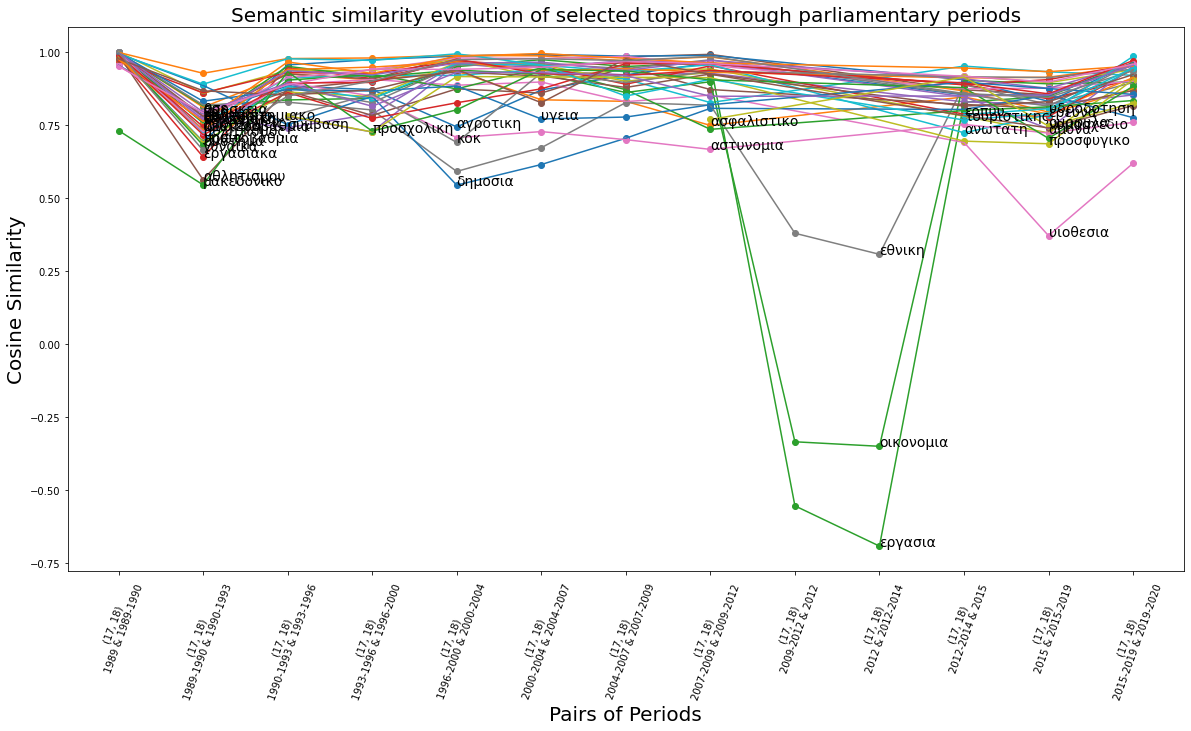

In [63]:
from collections import defaultdict
import matplotlib.pyplot as plt

plot_swift(vouliwatch_topics, df_similarities_2nd_order)

In [57]:
# df_similarities_2nd_order.columns

In [71]:
df_similarities_2nd_order = df_similarities_2nd_order.sort_values(by='period_pair')
df_similarities_2nd_order.to_csv('../out_files/selected_topics_cultural_shift_per_period_without_compass.csv', index=False)


In [70]:
df_similarities_2nd_order.head(2)

topic period_pair  cosine_similarity  neighbors_union  \
857        αμυνα      (5, 6)           0.998676               48   
761  πρωτοβαθμια      (5, 6)           0.983431               50   

                                          neighbors_t1  \
857  [δασων, αποτελεσματικοτητα, νομαρχιες, χαρις, ...   
761  [εσταλησαν, αντιστοιχου, αποδοχων, καταστηματω...   

                                          neighbors_t2  
857  [δημιουργουνται, κοινωνικα, στηριζονται, χαρακ...  
761  [ρολου, επιστημονικη, προωθησης, εγκυμονει, αδ...

### Merge small periods and check if results are the same with above

In [21]:
# <!-- ε_στ_ζ (5,6,7)
# ιδ_ιε (14, 15)
# ιστ_ιζ (16,17) -->

In [9]:
PERperiod_merged_df = PERperiod_df.copy()
PERperiod_merged_df.loc[(PERperiod_merged_df.period==5), 'period'] = 7
PERperiod_merged_df.loc[(PERperiod_merged_df.period==6), 'period'] = 7
PERperiod_merged_df.loc[(PERperiod_merged_df.period==14), 'period'] = 15
PERperiod_merged_df.loc[(PERperiod_merged_df.period==16), 'period'] = 17

In [10]:
print(list(set(PERperiod_merged_df.period.to_list())))

[7, 8, 9, 10, 11, 12, 13, 15, 17, 18]


In [11]:
from tqdm import tqdm
tqdm.pandas()

print(datetime.datetime.now())

#Group speeches by year
PERperiod_merged_df = PERperiod_merged_df.groupby(PERperiod_merged_df.period)['speech'].progress_apply(sum).reset_index()

print(datetime.datetime.now())

/Users/furiosa/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/tqdm/std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  0%|          | 0/10 [00:00<?, ?it/s]

2021-02-28 17:32:36.942036


100%|██████████| 10/10 [01:11<00:00,  7.18s/it]

2021-02-28 17:33:48.832714


In [13]:
PERperiod_merged_df.tail()
models_dir =  '../out_files/wordmodels/PERperiod_merged/'


In [35]:
models_dir =  '../out_files/wordmodels/PERperiod_merged/'
print(datetime.datetime.now())

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

for period, texts in tqdm(zip(PERperiod_merged_df.period, PERperiod_merged_df.speech)):
    if period in [7, 15, 17]:
        print(period)
        model = Word2Vec(sentences=texts, size=100, window=5, min_count=1, workers=4)
        model.save(models_dir+str(period) + ".mdl")
    
print(datetime.datetime.now())


0it [00:00, ?it/s]

2021-02-21 02:21:56.598526
7


1it [03:07, 187.65s/it]

15


8it [05:40, 137.91s/it]

17


10it [10:46, 64.63s/it]

2021-02-21 02:32:42.944683


In [14]:
def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]

periods_merged = sorted(PERperiod_merged_df.period.to_list())
print(periods_merged)

period_merged_pairs = step_one_pairs(periods_merged)
print(period_merged_pairs)

merged_models = {p:Word2Vec.load(f"../out_files/wordmodels/PERperiod_merged/{p}.mdl") for p in periods_merged}


[7, 8, 9, 10, 11, 12, 13, 15, 17, 18]
[(7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 15), (15, 17), (17, 18)]


In [43]:
similarities_2nd_order_merged = []

for topic in vouliwatch_topics:

    for pair in period_merged_pairs:
        
        t1, t2 = pair[0], pair[1]

        m1 = merged_models[t1]
#         print(m1)
        m2 = merged_models[t2]
        
        if (topic in m1.wv.vocab) and (topic in m2.wv.vocab):
        
            #union of neighbors in two points in time
            neighbors_t1 = [w for w,s in m1.wv.most_similar(positive=[topic], topn=25)]
            neighbors_t2 = [w for w,s in m2.wv.most_similar(positive=[topic], topn=25)]
            neighbors_t1_t2 = list(set(neighbors_t1+neighbors_t2))

            neighbors_union=[]
            # keep neighbors that are included in the compared model vocabularies
            for neighbor in neighbors_t1_t2:
                if (neighbor in m1.wv.vocab) and (neighbor in m2.wv.vocab):
                    neighbors_union.append(neighbor)
        #     print('Union of neighbors: ', str(len(neighbors_union)))

            # similarity vector for time point 1 (t1)
            # each element is the cosine similarity of topic vector in t1 and each neighbor from neighbors_union
            similarity_vector_t1 = []
            topic_vector_t1 = m1.wv[topic]
            for nn in neighbors_union:
                neighbor_vector = m1.wv[nn]
                similarity_vector_t1.append(cosine_similarity(X=topic_vector_t1.reshape(1,-1), Y=neighbor_vector.reshape(1,-1))[0][0])
        #     print(len(similarity_vector_t1))

            # similarity vector for time point 2 (t2)
            # each element is the cosine similarity of topic vector in t2 and each neighbor from neighbors_union
            similarity_vector_t2 = []
            topic_vector_t2 = m2.wv[topic]
            for nn in neighbors_union:
                neighbor_vector = m2.wv[nn]
                similarity_vector_t2.append(cosine_similarity(X=topic_vector_t2.reshape(1,-1), Y=neighbor_vector.reshape(1,-1))[0][0])
        #     print(len(similarity_vector_t2))

            #testing
        #     print(similarity_vector_t1)
        #     print(np.array([similarity_vector_t1]))
            # print(np.array(similarity_vector_t2).reshape(-1, 1))

            # final cosine between cosines/ similarity vectors for t1 and t2
            result = cosine_similarity(np.array([similarity_vector_t1]),
                                       np.array([similarity_vector_t2])
                                      )[0][0]

            similarities_2nd_order_merged.append([topic, pair, result, len(neighbors_union), neighbors_t1, neighbors_t2])
        #     break
        
        else:
            print(topic, ' not in vocabulary for periods ', str(pair))


df_similarities_2nd_order_merged = pd.DataFrame(data=similarities_2nd_order_merged, columns=['topic', 'period_pair', 'cosine_similarity', 'neighbors_union', 'neighbors_t1', 'neighbors_t2'])

df_similarities_2nd_order_merged = df_similarities_2nd_order_merged.sort_values('cosine_similarity', ascending=True).reset_index(drop=True)
print(df_similarities_2nd_order_merged.head(5))
df_similarities_2nd_order_merged.describe()


ημιαπασχοληση  not in vocabulary for periods  (7, 8)
ημιαπασχοληση  not in vocabulary for periods  (8, 9)
brain  not in vocabulary for periods  (7, 8)
brain  not in vocabulary for periods  (8, 9)
brain  not in vocabulary for periods  (9, 10)
brain  not in vocabulary for periods  (10, 11)
προσφυγικο  not in vocabulary for periods  (10, 11)
προσφυγικο  not in vocabulary for periods  (11, 12)
μεταναστευτικο  not in vocabulary for periods  (7, 8)
μεταναστευτικο  not in vocabulary for periods  (8, 9)
εκας  not in vocabulary for periods  (7, 8)
εκας  not in vocabulary for periods  (8, 9)
ομοφυλα  not in vocabulary for periods  (7, 8)
ομοφυλα  not in vocabulary for periods  (8, 9)
ομοφυλα  not in vocabulary for periods  (9, 10)
ομοφυλα  not in vocabulary for periods  (10, 11)
ομοφυλα  not in vocabulary for periods  (11, 12)
εοπυυ  not in vocabulary for periods  (7, 8)
εοπυυ  not in vocabulary for periods  (8, 9)
εοπυυ  not in vocabulary for periods  (9, 10)
εοπυυ  not in vocabulary for period

cosine_similarity  neighbors_union
count         715.000000       715.000000
mean            0.926040        37.921678
std             0.066692         5.697758
min             0.542893        15.000000
25%             0.906335        34.000000
50%             0.946333        38.000000
75%             0.970120        42.000000
max             0.995789        49.000000

In [30]:
import ast

df_similarities_2nd_order_merged = pd.read_csv('../out_files/selected_topics_cultural_shift_per_period_without_compass_merged_periods.csv',
                                               converters={"period_pair": ast.literal_eval})


In [52]:
import seaborn as sns

def plot_swift(vouliwatch_topics, df_similarities_2nd_order_merged):
    
    
    colors = sns.color_palette('colorblind').as_hex()
    plt.figure(figsize=(20, 10))
    
    for topic in tq.tqdm(vouliwatch_topics):

        topic_subdf = df_similarities_2nd_order_merged.loc[(df_similarities_2nd_order_merged.topic==topic)]
        
        if topic_subdf.shape[0]>0:
            
            topic_subdf = topic_subdf.sort_values('period_pair')
            period_pairs = topic_subdf.period_pair.to_list()
#             print(type(period_pairs[0]))
#             print(type(period_pairs[0]))
            X = [((pair[0])+pair[1])/2 for pair in period_pairs]
            Y = topic_subdf.cosine_similarity.to_list()
        
            # plot only those that go below 0.9
            if (not all(sim >= 0.7 for sim in Y)) or topic=='οικονομια':
                plt.scatter(X,Y)
                plt.plot(X,Y) # connect dots
                
                #annotate with topic name the lower point
                min_sim_index = Y.index(min(Y))

                plt.annotate(text=topic, 
                           xy=(X[min_sim_index],Y[min_sim_index]),
                             size=14
                           )
                
                print(topic)
                print(X[min_sim_index])
                print(Y[min_sim_index])
                print(topic_subdf.loc[(topic_subdf.cosine_similarity==Y[min_sim_index])].neighbors_t1.to_list())
                print(topic_subdf.loc[(topic_subdf.cosine_similarity==Y[min_sim_index])].neighbors_t2.to_list())

                
    #         break

    middle_pairs = [(pair[0]+pair[1])/2 for pair in step_one_pairs(periods_merged)]
    x_labels = [periods_to_dates(pair) for pair in step_one_pairs(periods_merged)]

    plt.xticks(middle_pairs,x_labels, rotation=70)

    plt.rcParams['figure.figsize'] = (10, 5)
    plt.rcParams['axes.labelsize'] = 19
    ax = plt.gca()
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
    
    plt.title('Semantic similarity evolution of selected topics through parliamentary periods (merged)', fontsize=20)
    plt.ylabel('Cosine Similarity', fontsize=20)
    plt.xlabel('Pairs of Periods', fontsize=20)
    plt.show()
    
#     plt.clf()
#     plt.cla()
#     plt.close()
#     fig.canvas.draw_idle()


def periods_to_dates(period_pair):
    
    period_dict_merged = { 7:'1989-1993',
                      8:'1993-1996',
                      9:'1996-2000',
                      10:'2000-2004',
                      11:'2004-2007',
                      12:'2007-2009',
                      13:'2009-2012', 
                      15:'2012-2014', 
                      17:'2015-2019', 
                      18:'2019-2020'}
    
    out = str(period_pair)+'\n'+period_dict_merged[period_pair[0]]+' & '+period_dict_merged[period_pair[1]]
    return(out)

print(periods_to_dates((15,17)))


(15, 17)
2012-2014 & 2015-2019


υιοθεσια
17.5
0.6260731220245361
["['αναδοχη', 'ομοφυλα', 'ζευγαρια', 'τεκνοθεσια', 'ζευγαριων', 'ανηλικους', 'ετεροφυλα', 'γεννηση', 'ιθαγενεια', 'ανατροφη', 'ανηλικων', 'ομοφυλοφιλα', 'αναδοχης', 'φυλου', 'ομοφυλο', 'ομοφυλων', 'αποιδρυματοποιηση', 'τεκνων', 'τεκνοθεσιας', 'κτηση', 'αναδοχοι', 'ενηλικιωση', 'παιδιων', 'πολιτογραφηση', 'υιοθεσιας']"]
["['αναδοχη', '4625', 'ανατεθηκε', 'παρατηρησης', 'διερευνητικων', 'προετοιμασε', 'ενταχθηκε', 'αμερικο', 'βιδωσει', '1397', 'παλαιο', 'σχεδιαστηκε', 'πινοσετ', 'εγκαθιστα', 'διαταζατε', '3299', 'μυασθενεια', 'περιβοητης', 'κλιματισμου', 'δεκανεας', 'βερμπαλιστικο', 'αρθριτιδα', 'llc', 'συναρτα', 'επαχθων']"]
εθνικη
9.5
0.5897167325019836
["['δεξιωνεται', 'ιρανικη', 'στηνεθνικη', 'mercedes', 'χειμαζουσων', 'τηνεθνικη', 'ελλαδος', 'κεντρκη', 'επικυρωμενες', 'παλλαικη', 'αγροτικη', 'πεκινο', 'eμπορικη', 'ελληνικη', 'παρακειμενης', 'αποχαιρετουμε', 'αλληθεση', 'συμπληρωνετο', 'ελλαδας', 'αποσπαματικα', 'επενδυομενο', 'συντηριτικο', '2211', '

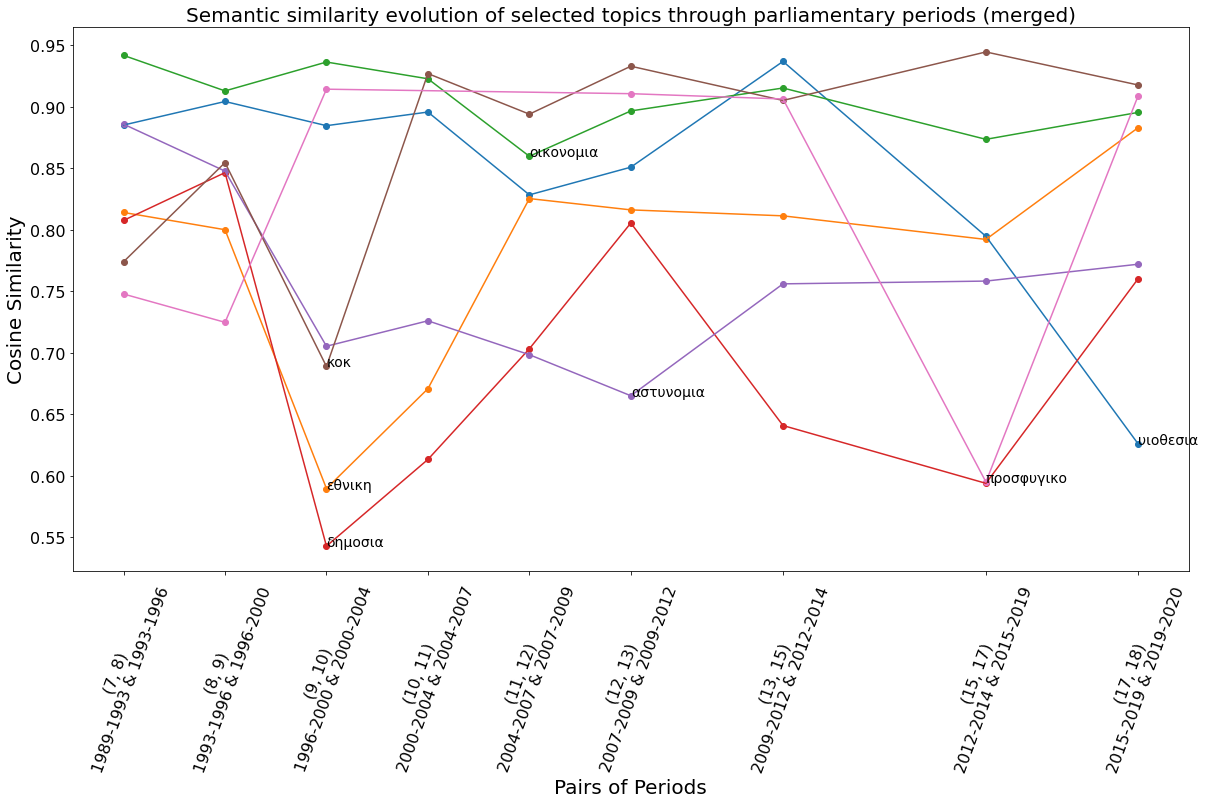

In [53]:
from collections import defaultdict
import matplotlib.pyplot as plt
# print(df_similarities_2nd_order_merged.columns)
plot_swift(vouliwatch_topics, df_similarities_2nd_order_merged)


In [55]:
df_similarities_2nd_order_merged = df_similarities_2nd_order_merged.sort_values(by='period_pair')
df_similarities_2nd_order_merged.to_csv('../out_files/selected_topics_cultural_shift_per_period_without_compass_merged_periods.csv', index=False)


In [27]:
# print(int('10'))

10


In [54]:
df_similarities_2nd_order_merged.head(2)

topic period_pair  cosine_similarity  neighbors_union  \
0  επιχειρησεις      (7, 8)           0.934621               39   
1        ερευνα      (7, 8)           0.927301               46   

                                        neighbors_t1  \
0  ['εταιρειες', 'εταιριες', 'βιομηχανιες', 'τραπ...   
1  ['μελετη', 'εξεταση', 'προετοιμασια', 'παρακολ...   

                                        neighbors_t2  
0  ['τραπεζες', 'εταιρειες', 'κεφαλαια', 'βιωσιμε...  
1  ['γνωση', 'μεριμνα', 'ελεγξει', 'τεχνικη', 'ιε...